<a href="https://colab.research.google.com/github/deguc/Shannon/blob/main/002_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

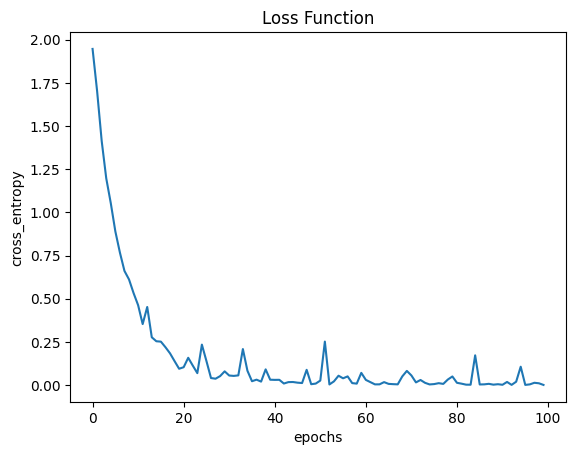

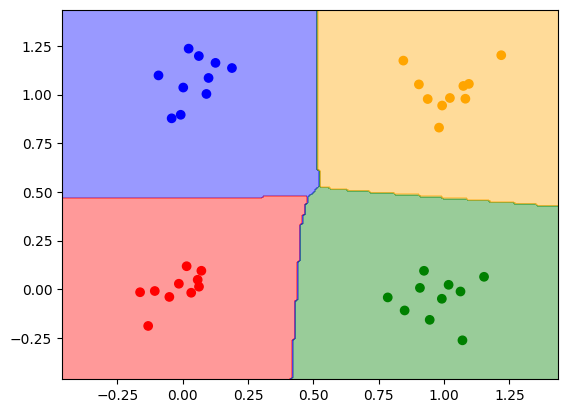

[0 1 2 3]


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def onehot(x):

    k = x.max()+1

    return np.identity(k)[x]


def dataset(x,y,size=10,scale=0.1):

    X,Y = [],[]
    k = x.shape[1]

    for x0,y0 in zip(x,y):

        X += [x0+np.random.randn(size,k)*scale]
        Y += [np.full(size,y0)]

    return np.vstack(X),onehot(np.hstack(Y))


class DataLoader:

    def __init__(self,dataset,batch_size=10):

        self.x,self.y = dataset
        self.batch_size = batch_size
        self.data_size = self.x.shape[0]
        self.cnt = 0

    def __len__(self):

        return self.data_size // self.batch_size

    def shuffle(self):

        idx = np.random.permutation(self.data_size)

        self.x,self.y = self.x[idx],self.y[idx]

    def __iter__(self):
        return self

    def __getitem__(self,idx):

        if idx < 0 or idx >= len(self):
            raise IndexError('out of range')

        i = idx*self.batch_size
        j = i + self.batch_size

        return self.x[i:j],self.y[i:j]

    def __next__(self):

        if self.cnt == 0:
            self.shuffle()

        i = self.cnt
        j = i + self.batch_size

        if j > self.data_size:
            self.cnt = 0
            raise StopIteration
        else:
            self.cnt = j
            return self.x[i:j],self.y[i:j]


def zeros_ps(ps):

    gs = []

    for p in ps:
        gs += [np.zeros_like(p)]

    return gs


class Module:

    def __init__(self):

        self.ps,self.gs = [],[]
        self.inputs = None
        self.mask = None
        self.train_flag = False


class Linear(Module):

    def __init__(self,d_in,d_out):
        super().__init__()
        std = np.sqrt(d_in/2)
        self.ps = [
            np.random.randn(d_in,d_out)/std,
            np.zeros(d_out)
        ]
        self.gs = zeros_ps(self.ps)

    def __call__(self,x):

        self.inputs = x

        return x @ self.ps[0] + self.ps[1]

    def backward(self,dout):

        self.gs[0][...] = self.inputs.T @ dout
        self.gs[1][...] = np.sum(dout,axis=0)

        return dout @ self.ps[0].T


class ReLU(Module):

    def __init__(self):
        super().__init__()

    def __call__(self,x):

        self.mask = x < 0
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self,dout):

        dout[self.mask] = 0

        return dout


class Layers:

    def __init__(self,layers):

        self.layers = layers
        self.ps = [[],[]]

        for l in layers:
            self.ps[0] += l.ps
            self.ps[1] += l.gs

    def __call__(self,x):

        for l in self.layers:
            x = l(x)

        return x

    def backward(self,dout):

        for l in reversed(self.layers):
            dout = l.backward(dout)

    def train(self):

        for l in self.layers:
            l.train_flag = True

    def eval(self):

        for l in self.layers:
            l.train_flag = False

    def pred(self,x):

        return np.argmax(self(x),axis=-1)


class AdamW:

    def __init__(self,ps,lr=0.1,beta1=0.2,beta2=0.9,weight_decay=0.1):

        self.ps = ps
        self.cache = (lr,beta1,beta2,weight_decay)
        self.hs =[
            zeros_ps(ps[0]),
            zeros_ps(ps[0])
        ]
        self.cnt = 0

    def __call__(self):

        eps = 1e-6
        ps,gs = self.ps
        ms,vs = self.hs
        lr,b1,b2,w = self.cache
        self.cnt += 1
        n = self.cnt

        for p,g,m,v in zip(ps,gs,ms,vs):

            m[...] = b1*m + (1-b1)*g
            v[...] = b2*v + (1-b2)*g*g

            m0 = m / (1-b1**n)
            v0 = v / (1-b2**n)

            p -= w*lr*g

            p -= lr*m0/(np.sqrt(v0)+eps)


def softmax(x):

    c = np.max(x,axis=-1,keepdims=True)
    e = np.exp(x-c)
    z = np.sum(e,axis=-1,keepdims=True)

    return e/z


def cross_entropy(y,t):

    eps = 1e-6

    return -np.sum(t*np.log(y+eps))/y.shape[0]


class Loss:

    def __init__(self,model,clf=softmax,loss=cross_entropy):

        self.clf = clf
        self.loss = loss
        self.model = model
        self.dout = 1

    def __call__(self,y,t):

        out = self.clf(y)
        self.dout = (out - t)/y.shape[0]

        return self.loss(out,t)

    def backward(self):

        self.model.backward(self.dout)


def trainer(model,loss,optimizer,data,epochs):

    ls = []

    for _ in range(epochs):

        model.train()

        l = 0

        for x,t in data:

            y = model(x)
            l += loss(y,t)
            loss.backward()
            optimizer()

        ls += [l/len(data)]

        model.eval()

    return ls


def disp_loss(loss):

    plt.title('Loss Function')
    plt.xlabel('epochs')
    plt.ylabel('cross_entropy')
    plt.plot(loss)
    plt.show()

def decision_regions(pred,data,resolution=200):

    x = data.x
    y = np.argmax(data.y,axis=-1)

    colors = ['red','blue','green','orange','gray']
    c = [colors[i] for i in y]
    cmap = ListedColormap(colors[:y.max()+1])

    x_min = x.min() - 0.2
    x_max = x.max() + 0.2

    x1 = np.linspace(x_min,x_max,resolution)
    x2 = np.linspace(x_min,x_max,resolution)
    xx1,xx2 = np.meshgrid(x1,x2)
    xx = np.array([xx1.flatten(),xx2.flatten()]).T
    z = pred(xx).reshape(xx1.shape)

    plt.contourf(xx1,xx2,z,cmap=cmap,alpha=0.4)

    plt.scatter(x[:,0],x[:,1],c=c)
    plt.show()


class Dropout(Module):

    def __init__(self,drop_rate=0.1):
        super().__init__()

        self.drop_rate = drop_rate

    def __call__(self,x):

        if self.train_flag:
            r = self.drop_rate
        else:
            r = 0

        self.mask = np.random.rand(*x.shape) > r

        return x*self.mask/(1-r)

    def backward(self,dout):

        return dout*self.mask/(1-self.drop_rate)

class BatchNorm(Module):

    def __init__(self,dim):

        self.ps = [
            np.ones(dim),
            np.zeros(dim)
        ]
        self.gs = zeros_ps(self.ps)

        self.mu = np.zeros(dim)
        self.var = np.ones(dim)

        self.cache = None
        self.eps = 1e-6

    def __call__(self,x):

        if self.train_flag:

            mu = np.mean(x,axis=0)
            var = np.var(x,axis=0)
            centered = x-mu
            std_inv = 1/np.sqrt(var+self.eps)
            norm = centered * std_inv
            self.cache = (centered,std_inv,norm)

            self.mu[...] = 0.9*self.mu + 0.1*mu
            self.var[...] = 0.9*self.var + 0.1*var

        else:

            norm = (x-self.mu) /np.sqrt(self.var+self.eps)

        return norm * self.ps[0] + self.ps[1]

    def backward(self,dout):

        centered,std_inv,norm = self.cache

        self.gs[0][...] = np.sum(norm*dout,axis=0)
        self.gs[1][...] = np.sum(dout,axis=0)

        dnorm = dout * self.ps[0]
        dvar = np.sum(-0.5*dnorm*centered*std_inv**3,axis=0)
        dmu = -np.sum(dnorm*std_inv,axis=0)-np.mean(2.0*dvar*centered,axis=0)

        N = dout.shape[0]

        return dnorm*std_inv + 2.0*dvar*centered/N + dmu/N


np.set_printoptions(precision=2,suppress=True)

x = np.array([[0,0],[0,1],[1,0],[1,1]])
y = np.array([0,1,2,3])

dataset = dataset(x,y,size=10,scale=0.1)
data = DataLoader(dataset,batch_size=10)

d_in = x.shape[1]
d_h = 4*d_in
d_out = y.max()+1

layers = [
    Linear(d_in,d_h),
    BatchNorm(d_h),
    ReLU(),
    Dropout(drop_rate=0.02),
    Linear(d_h,d_out)
]

model = Layers(layers)
loss = Loss(model)
optimizer = AdamW(model.ps,lr=0.01)
epochs = 100
ls = trainer(model,loss,optimizer,data,epochs)

disp_loss(ls)
decision_regions(model.pred,data)

pred = model.pred(x)
print(pred)